# Cyanobacteria Toxicity Classification Notebook with Cross-Validation

## 1. Setup & Configuration

In [2]:
import os
from datetime import date
import math
import subprocess
import yaml
import pandas as pd
import torch
from torchvision.models import ResNet18_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision import models, datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from src.config_utils import load_config
from PIL import Image
import copy
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torchvision.transforms as T
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    brier_score_loss
)
from sklearn.calibration import calibration_curve
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Chargement de la config
config = load_config(path='../configs/config_finetune_resnet18.yaml')

# Répertoires de sortie
FIG_OUT = os.path.join('..', 'outputs', 'figures', 'Switzerland', 'finetune_resnet18')
os.makedirs(FIG_OUT, exist_ok=True)

# Génération du Run ID : date + commit Git
today = date.today().isoformat()
commit = subprocess.check_output(["git","rev-parse","--short","HEAD"]).decode().strip()
run_id = f"{today}_{commit}"

print("Run ID :", run_id)


Run ID : 2025-07-23_9243430


## 2. Data Preparation

In [3]:
# Transforms avec RandomErasing pour dropout spatial
data_cfg = config['augmentation']

train_transform = T.Compose([
    # 1) Crop aléatoire + scale varié
    T.RandomResizedCrop(size=tuple(data_cfg['resize']),
                        scale=(0.8, 1.0)),
    # 2) Flips horizontal + vertical
    T.RandomHorizontalFlip(p=0.5 if data_cfg['horizontal_flip'] else 0.0),
    T.RandomVerticalFlip(p=0.5 if data_cfg['vertical_flip'] else 0.0),
    # 3) Rotation légère
    T.RandomRotation(degrees=data_cfg['rotation']),
    # 4) Variation colorimétrique
    T.ColorJitter(brightness=data_cfg['color_jitter']['brightness'],
                  contrast=  data_cfg['color_jitter']['contrast'],
                  saturation=data_cfg['color_jitter']['saturation'],
                  hue=       data_cfg['color_jitter']['hue']),
    # 5) Passage en tenseur + normalisation
    T.ToTensor(),
    T.Normalize(mean=data_cfg['normalization']['mean'],
                std= data_cfg['normalization']['std']),
    # 6) Masquage partiel (Random Erasing)
    T.RandomErasing(p=data_cfg['random_erasing']['p'],
                    scale=tuple(data_cfg['random_erasing']['scale']),
                    ratio=tuple(data_cfg['random_erasing']['ratio']))
])

val_transform = transforms.Compose([
    transforms.Resize(tuple(data_cfg['resize'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_cfg['normalization']['mean'],
                         std=data_cfg['normalization']['std'])
])


In [4]:
# Chargement du dataset et Stratified K-Fold
dataset = datasets.ImageFolder(root=os.path.join('..', config['data']['path']),
                               transform=train_transform)
targets = np.array(dataset.targets)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_to_use = 0  # modifier si besoin (0 à 4)
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    if fold == fold_to_use:
        print(f"=== Fold {fold+1} sélectionné ===")
        break

# Subsets et DataLoaders
train_subset = Subset(dataset, train_idx)
# val_transform pour la validation
val_dataset_full = datasets.ImageFolder(root=os.path.join('..', config['data']['path']),
                                        transform=val_transform)
val_subset = Subset(val_dataset_full, val_idx)

train_loader = DataLoader(train_subset,
                          batch_size=config['data']['batch_size'],
                          shuffle=True,
                          num_workers=config['data']['num_workers'])
val_loader = DataLoader(val_subset,
                        batch_size=config['data']['batch_size'],
                        shuffle=False,
                        num_workers=config['data']['num_workers'])


=== Fold 1 sélectionné ===


## 3. Model Definition

In [5]:
# === EarlyStopping utility ===
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


In [8]:
# Définition du modèle, critère et optimizer
device = torch.device(config['training']['device'])
model = models.resnet18(
    weights=ResNet18_Weights.DEFAULT if config['model']['pretrained'] else None
)

# 1) Geler toutes les couches backbone
for param in model.parameters():
    param.requires_grad = False

# 2) Nouvelle tête avec Dropout
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(num_ftrs, config['model']['num_classes'])
)

# 3) Débloquer la tête puis layer4
for param in model.fc.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    if name.startswith("layer4"):
        param.requires_grad = True

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Optimiseur AdamW
base_lr = float(config['training']['learning_rate'])
params = [
    {"params": model.layer4.parameters(), "lr": base_lr * 0.1},
    {"params": model.fc.parameters(),    "lr": base_lr}
]

optimizer = optim.AdamW(params, weight_decay=float(config['training']['weight_decay']))

# Scheduler ReduceLROnPlateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode=config['scheduler']['mode'],
    factor=config['scheduler']['factor'],
    patience=config['scheduler']['patience'],
    min_lr=config['scheduler']['min_lr']
)

# Instancier EarlyStopping
early_stopper = EarlyStopping(patience=5, min_delta=1e-4)


## 4. Training Loop

In [9]:
# Boucle d'entraînement
history = {'train_loss': [], 'val_loss': []}
num_epochs = config['training']['epochs']

for epoch in range(num_epochs):
    # ---- Entraînement ----
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    history['train_loss'].append(epoch_train_loss)

    # ---- Validation ----
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    history['val_loss'].append(epoch_val_loss)

    scheduler.step(epoch_val_loss)

    if early_stopper(epoch_val_loss):
        print(f"Early stopping à l'epoch {epoch+1}")
        break

    print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {epoch_train_loss:.4f} — Val Loss: {epoch_val_loss:.4f}")


Epoch 1/20 - Train: 100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


Epoch 1/20 — Train Loss: 0.7177 — Val Loss: 0.6738


Epoch 2/20 - Train: 100%|██████████| 30/30 [00:38<00:00,  1.27s/it]


Epoch 2/20 — Train Loss: 0.6192 — Val Loss: 0.5629


Epoch 3/20 - Train: 100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


Epoch 3/20 — Train Loss: 0.5430 — Val Loss: 0.5177


Epoch 4/20 - Train: 100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


Epoch 4/20 — Train Loss: 0.5349 — Val Loss: 0.4760


Epoch 5/20 - Train: 100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


Epoch 5/20 — Train Loss: 0.4619 — Val Loss: 0.4773


Epoch 6/20 - Train: 100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


Epoch 6/20 — Train Loss: 0.4671 — Val Loss: 0.4527


Epoch 7/20 - Train: 100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


Epoch 7/20 — Train Loss: 0.4315 — Val Loss: 0.4363


Epoch 8/20 - Train: 100%|██████████| 30/30 [00:38<00:00,  1.27s/it]


Epoch 8/20 — Train Loss: 0.4339 — Val Loss: 0.4241


Epoch 9/20 - Train: 100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


Epoch 9/20 — Train Loss: 0.4146 — Val Loss: 0.4217


Epoch 10/20 - Train: 100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


Epoch 10/20 — Train Loss: 0.3666 — Val Loss: 0.4296


Epoch 11/20 - Train: 100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


Epoch 11/20 — Train Loss: 0.3933 — Val Loss: 0.3970


Epoch 12/20 - Train: 100%|██████████| 30/30 [00:38<00:00,  1.29s/it]


Epoch 12/20 — Train Loss: 0.3646 — Val Loss: 0.3747


Epoch 13/20 - Train: 100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


Epoch 13/20 — Train Loss: 0.3532 — Val Loss: 0.3719


Epoch 14/20 - Train: 100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


Epoch 14/20 — Train Loss: 0.3760 — Val Loss: 0.4011


Epoch 15/20 - Train: 100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


Epoch 15/20 — Train Loss: 0.3512 — Val Loss: 0.3571


Epoch 16/20 - Train: 100%|██████████| 30/30 [00:47<00:00,  1.57s/it]


Epoch 16/20 — Train Loss: 0.3373 — Val Loss: 0.3536


Epoch 17/20 - Train: 100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


Epoch 17/20 — Train Loss: 0.3607 — Val Loss: 0.3586


Epoch 18/20 - Train: 100%|██████████| 30/30 [00:38<00:00,  1.29s/it]


Epoch 18/20 — Train Loss: 0.3189 — Val Loss: 0.3525


Epoch 19/20 - Train: 100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


Epoch 19/20 — Train Loss: 0.2841 — Val Loss: 0.3381


Epoch 20/20 - Train: 100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


Epoch 20/20 — Train Loss: 0.3322 — Val Loss: 0.3398


## 5. Results Visualization

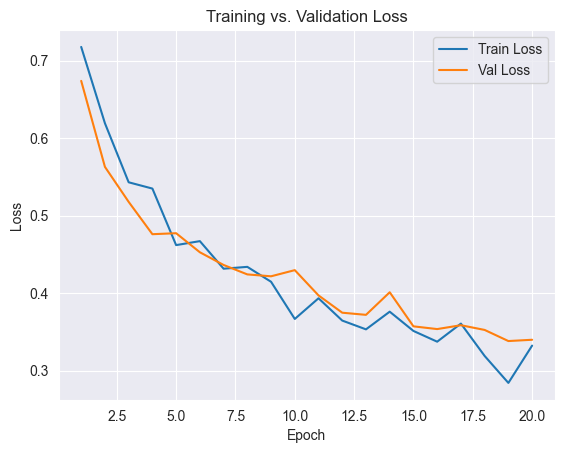

In [10]:
# Affichage des courbes de perte
epochs = np.arange(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_loss_curve.png"), dpi=300)
plt.show()


In [11]:
# Collecte des vraies étiquettes et des probabilités sur la validation
model.eval()
y_true = []
y_prob = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]
        y_prob.extend(probs.cpu().numpy())
        y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_prob = np.array(y_prob)


In [12]:
# Seuil optimisé à partir de la PR-curve (max F1)
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Seuil optimal (PR-curve) : {best_threshold:.4f} — F1 : {f1_scores[best_idx]:.4f}")


Seuil optimal (PR-curve) : 0.4226 — F1 : 0.8947


ROC AUC : 0.9287 — Average Precision (AP) : 0.9504


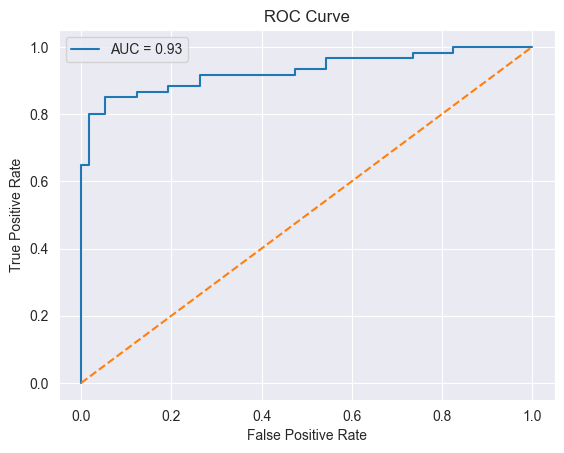

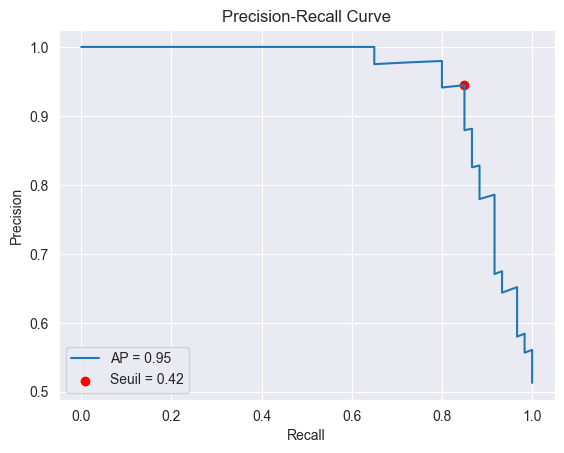

In [13]:
# Calcul des métriques et tracé ROC / PR
y_pred = (y_prob >= best_threshold).astype(int)

# Matrices et scores
cm = confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)

print(f"ROC AUC : {roc_auc:.4f} — Average Precision (AP) : {ap:.4f}")

# ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_roc_curve.png"), dpi=300)
plt.show()

# PR
plt.figure()
plt.plot(recall, precision, label=f'AP = {ap:.2f}')
plt.scatter(recall[best_idx], precision[best_idx], color='red',
            label=f'Seuil = {best_threshold:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_pr_curve.png"), dpi=300)
plt.show()


In [14]:
# Calibration + Brier score
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
brier = brier_score_loss(y_true, y_prob)
print(f"Brier score : {brier:.4f}")


Brier score : 0.1041


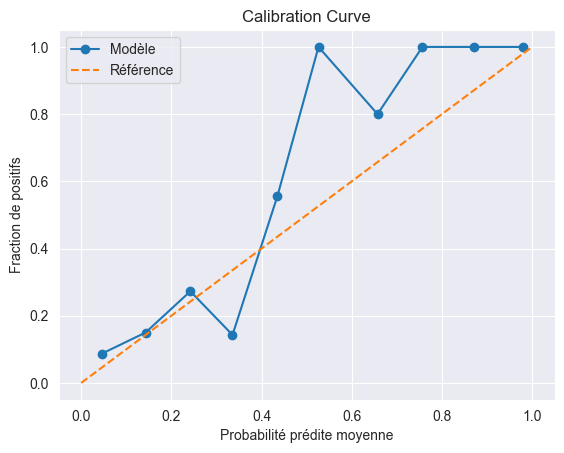

In [15]:
# Tracé de la calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='Modèle')
plt.plot([0,1], [0,1], '--', label='Référence')
plt.xlabel('Probabilité prédite moyenne')
plt.ylabel('Fraction de positifs')
plt.title('Calibration Curve')
plt.legend()
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_calibration_curve.png"), dpi=300)
plt.show()


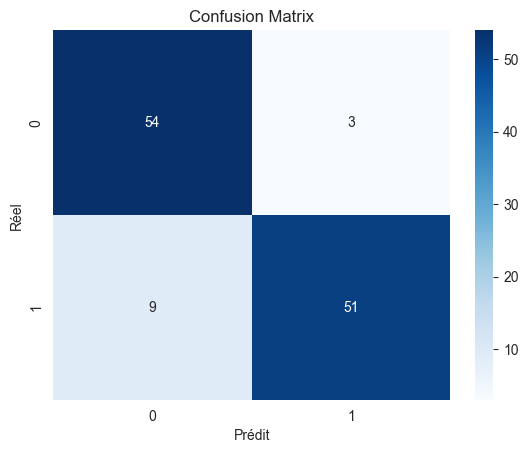

In [16]:
# Matrice de confusion (heatmap)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_confusion_matrix.png"), dpi=300)
plt.show()


In [17]:
# Classification report détaillé
print("Classification Report :")
print(classification_report(y_true, y_pred))


Classification Report :
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        57
           1       0.94      0.85      0.89        60

    accuracy                           0.90       117
   macro avg       0.90      0.90      0.90       117
weighted avg       0.90      0.90      0.90       117



## 6. Grad-CAM Interpretability

Images sauvegardées dans : ../outputs/figures/Switzerland/finetune_resnet18/2025-07-23_9243430_gradcam_batch.png


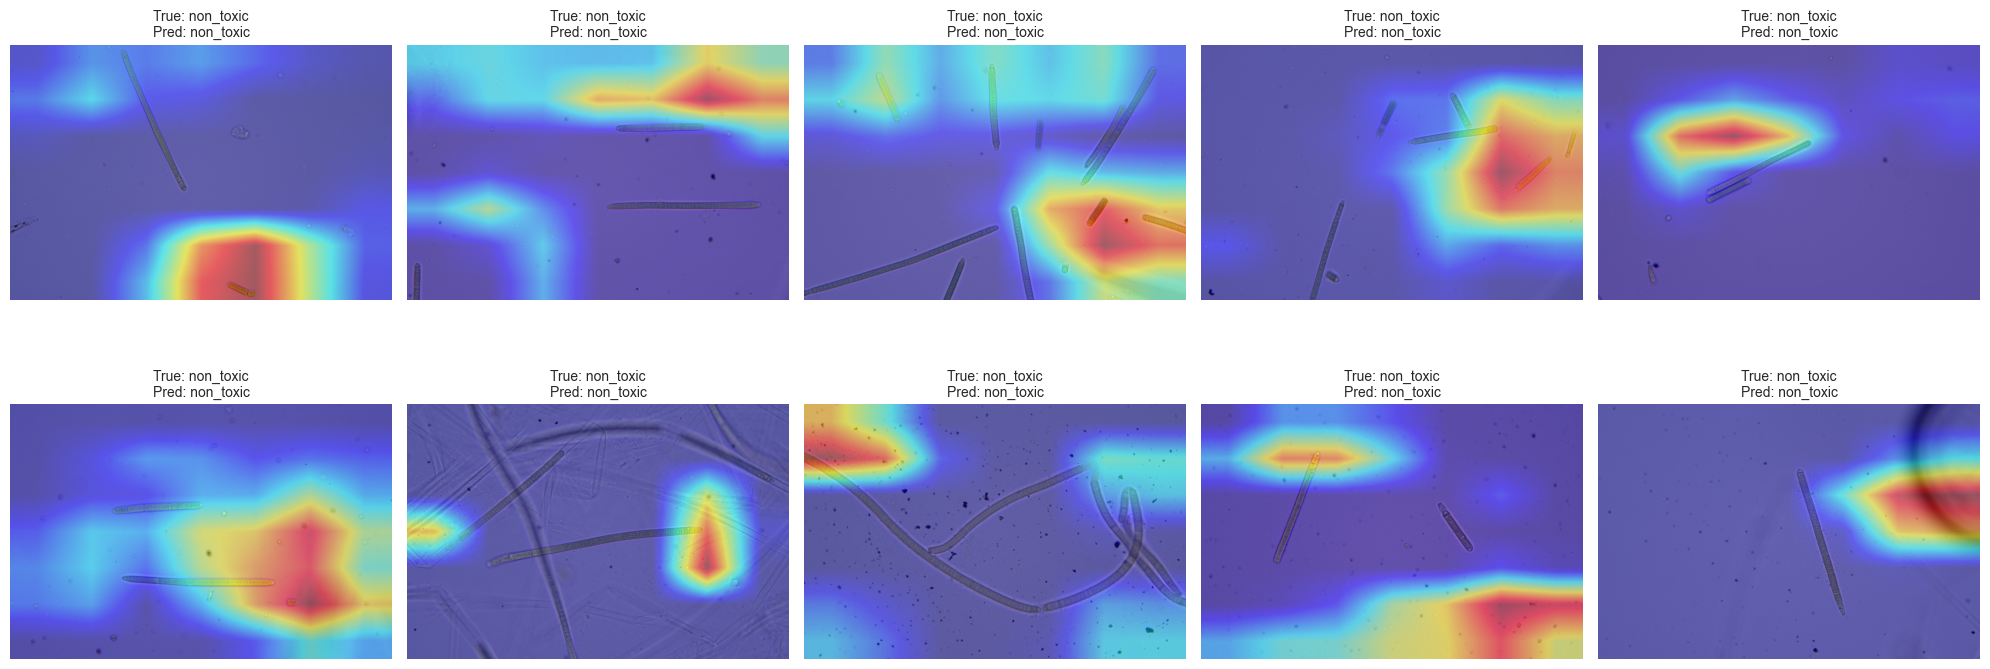

In [18]:
# Récupérer mean et std depuis la config
mean = data_cfg['normalization']['mean']
std  = data_cfg['normalization']['std']

# Transformations pour la visualisation
vis_transform = transforms.Compose([
    transforms.Resize(tuple(data_cfg['resize'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Préparer GradCAM
target_layer = model.layer4[1].conv2
cam_extractor = GradCAM(model=model, target_layers=[target_layer])

# Nombre d'images à afficher
n_display = 10
n_cols = 5
n_rows = math.ceil(n_display / n_cols)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(n_cols * 4, n_rows * 4),
                         dpi=100)
axes = axes.flatten()

classes = val_subset.dataset.classes

for idx in range(n_display):
    ax = axes[idx]

    # Récupérer le chemin et le label vrai
    sample_idx = val_subset.indices[idx]
    img_path, true_label = val_subset.dataset.samples[sample_idx]
    orig_img = Image.open(img_path).convert('RGB')
    W, H = orig_img.size

    # Préparer l'image d'entrée
    orig_resized = transforms.Resize(tuple(data_cfg['resize']))(orig_img)
    input_tensor = vis_transform(orig_resized).unsqueeze(0).to(device)
    input_tensor.requires_grad_(True)

    # Prédiction du modèle
    outputs = model(input_tensor)
    pred_label = outputs.argmax(dim=1).item()

    targets = [ClassifierOutputTarget(pred_label)]

    # Calcul du Grad-CAM
    grayscale_cam = cam_extractor(
        input_tensor=input_tensor,
        targets=targets
    )[0]

    # Redimensionner la carte sur l'image originale
    cam_img = Image.fromarray((grayscale_cam * 255).astype(np.uint8))
    cam_img = cam_img.resize((W, H), resample=Image.BILINEAR)
    cam_resized = np.array(cam_img, dtype=np.float32) / 255.0

    # Superposer la carte sur l'image originale
    rgb_orig = np.array(orig_img, dtype=np.float32) / 255.0
    cam_on_image = show_cam_on_image(rgb_orig, cam_resized, use_rgb=True)

    ax.imshow(cam_on_image)
    ax.set_title(f"True: {classes[true_label]}\nPred: {classes[pred_label]}", fontsize=10)
    ax.axis('off')

# Cacher les axes restants
for ax in axes[n_display:]:
    ax.axis('off')

plt.tight_layout()

# Sauvegarde de la figure
fig_path = os.path.join(FIG_OUT, f"{run_id}_gradcam_batch.png")
plt.savefig(fig_path, dpi=300)
print("Images sauvegardées dans :", fig_path)
plt.show()

## 7. Save Model & Config

In [19]:
# Sauvegarde du modèle et de la config
os.makedirs('../outputs/checkpoints/Switzerland/finetune_resnet18', exist_ok=True)
torch.save(model.state_dict(),
           f'../outputs/checkpoints/Switzerland/finetune_resnet18/{run_id}_model.pth')

os.makedirs('../outputs/configs/Switzerland', exist_ok=True)
with open(f'../outputs/configs/Switzerland/{run_id}_config_finetune_resnet18.yaml', 'w') as f:
    yaml.dump(config, f)

print('Entraînement terminé. Modèle et config enregistrés.')


Entraînement terminé. Modèle et config enregistrés.
